In [2]:
from torch import normal
from torch import tensor
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    transforms.Resize((128, 128))])

celebs=datasets.CelebA(root='./celeb/', 
                       transform=transform,
                       download=True)

Files already downloaded and verified


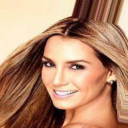

In [4]:
import torchvision as tv
display_trans=tv.transforms.ToPILImage()

# Returns PIL Image from tensor data with pixel RGB values ranging from -1 to 1
def tensorToImage(t, func=lambda x : (x+1)/2):
    display_trans=tv.transforms.ToPILImage()
    return display_trans(func(t))

tensorToImage(celebs[0][0])

In [5]:
# tensor of feature attributes
celebs[0][1]

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [6]:
import torch
im=celebs[0][0]
im.shape

torch.Size([3, 128, 128])

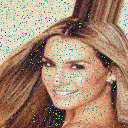

In [7]:
from math import sqrt
# example run of adding gaussian noise to image
var=0.02
im=normal(mean=sqrt(1-sqrt(0.1))*im, std=sqrt(var))

tensorToImage(im)

In [8]:
from math import sqrt
# adds noise to image with var and shifts mean towards 0 using sqrt(1-var)
def add_noise(image, var):
    return normal(mean=sqrt(1-var)*image, std=sqrt(var))


In [9]:
im=celebs[0][0]

In [10]:
images=[]
for i in range(20):
    im=add_noise(im, 0.02)
    images.append(im)
# display(*[tensorToImage(x) for x in images])

In [11]:
im=celebs[0][0]
# adds gaussian noise to image sequentially following var_scheduler variance
def forward_process(image, var_scheduler=torch.linspace(start=1e-4, end=0.5, steps=100)):
    images=[]
    for var in var_scheduler:
        image=add_noise(image, var)
        images.append(image)
    return images

# puts image through forward process then prints each iteration of process
images=forward_process(im)
# display(*[tensorToImage(x) for i, x in enumerate(images) if i%10==0])
    

In [12]:
from torch import nn

# Returns double convolution model with output of shape num_filters x H x W
def double_conv(in_channels, num_filters):
    return 

# Takes in input and number of filters desired and returns output of double convolution with shape N x num_filters x H x W
def conv_block(input, num_filters):
    return nn.Sequential(
        nn.Conv2d(in_channels=input.shape[1], out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True)
    )


In [13]:
from torch.utils import data

# Getting random samples from celebs dataset
random_sampler = data.RandomSampler(celebs, num_samples=10)
dataloader = data.DataLoader(celebs, batch_size=10, sampler=random_sampler)

# Turning dataloader object into a tensor so it is passable into conv_block for testing
celeb_tensor=tensor([])
for i, d in enumerate(dataloader):
    celeb_tensor=torch.cat((celeb_tensor, d[0]), 0)

for celeb in celeb_tensor:
    print(celeb.shape)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


In [14]:
with torch.no_grad():
    x1=conv_block(celeb_tensor, 64)(celeb_tensor)
    print(x1.shape)
    x2=conv_block(x1, 128)(x1)
    print(x2.shape)
    x3=conv_block(x2, 256)(x2)
    print(x3.shape)

torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 128, 128])
torch.Size([10, 256, 128, 128])


In [15]:
def down_block(input, num_filters):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=(2,2)),
        conv_block(input, num_filters)
    )
with torch.no_grad():
    layer1=conv_block(celeb_tensor, 64)(celeb_tensor)
    layer2=down_block(layer1, 128)(layer1)
layer1.shape, layer2.shape

(torch.Size([10, 64, 128, 128]), torch.Size([10, 128, 64, 64]))

In [16]:
with torch.no_grad():
    num_filters=64
    x1=conv_block(celeb_tensor, num_filters)(celeb_tensor)
    x2=down_block(x1, num_filters*2)(x1)
    x3=down_block(x2, num_filters*4)(x2)
    x4=down_block(x3, num_filters*8)(x3)
print(x1.shape, x2.shape, x3.shape, x4.shape)

torch.Size([10, 64, 128, 128]) torch.Size([10, 128, 64, 64]) torch.Size([10, 256, 32, 32]) torch.Size([10, 512, 16, 16])


In [17]:
def up_block(input, skip_connection, num_filters):
    # variables for padding when previous layer was uneven value
    diffH=skip_connection.shape[2]-input.shape[2]*2
    diffW=skip_connection.shape[3]-input.shape[3]*2
    # upsample input
    upsample=nn.ConvTranspose2d(in_channels=input.shape[1], out_channels=num_filters, kernel_size=(2, 2), stride=2, padding=0, output_padding=(diffW-diffW//2, diffH-diffH//2))(input)
    cat=torch.cat([skip_connection, upsample], dim=1)
    return cat, conv_block(cat, num_filters)


In [18]:
# TESTING UPBLOCK
with torch.no_grad():
    x1=conv_block(celeb_tensor, num_filters)(celeb_tensor)
    x2=down_block(x1, num_filters*2)(x1)
    x3=down_block(x2, num_filters*4)(x2)
    new_input, up_model=up_block(x3, x2, num_filters*2)
    print('concatenated input', new_input.shape)
    print(up_model(new_input).shape)
    print(x1.shape, x2.shape, x3.shape)
    x4=nn.MaxPool2d(kernel_size=(2,2))(x1)
    print(x1.shape, x4.shape)

concatenated input torch.Size([10, 256, 64, 64])
torch.Size([10, 128, 64, 64])
torch.Size([10, 64, 128, 128]) torch.Size([10, 128, 64, 64]) torch.Size([10, 256, 32, 32])
torch.Size([10, 64, 128, 128]) torch.Size([10, 64, 64, 64])


In [19]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, num_filters) -> None:
        super(Conv_Block, self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Down_Block(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(Down_Block, self).__init__()
        self.down=nn.Sequential(
            nn.MaxPool2d(kernel_size=(2,2)),
            Conv_Block(in_channels, num_filters)
        )

    def forward(self, input):
        return self.down(input)
    
class Up_Block(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(Up_Block, self).__init__()
        self.upsample=nn.ConvTranspose2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(2,2), stride=2, padding=0)
        self.conv=Conv_Block(in_channels, num_filters)

    def forward(self, input, skip_connection):
        diffH=skip_connection.shape[2]-input.shape[2]*2
        diffW=skip_connection.shape[3]-input.shape[3]*2
        upsampled_input=self.upsample(input)
        upsampled_input=nn.functional.pad(upsampled_input, (diffW//2, diffW-diffW//2, diffH//2, diffH-diffH//2))
        cat_input=torch.cat([skip_connection, upsampled_input], dim=1)
        return self.conv(cat_input)


class Unet(nn.Module):
    def __init__(self, in_channels, num_filters, out_channels):
        super(Unet, self).__init__()
        self.llayer1=Conv_Block(in_channels, num_filters)
        self.llayer2=Down_Block(num_filters, num_filters*2)
        self.llayer3=Down_Block(num_filters*2, num_filters*4)
        self.bottom=Down_Block(num_filters*4, num_filters*8)
        self.rlayer3=Up_Block(num_filters*8, num_filters*4)
        self.rlayer2=Up_Block(num_filters*4, num_filters*2)
        self.rlayer1=Up_Block(num_filters*2, num_filters)
        self.out_conv=nn.Conv2d(in_channels=num_filters, out_channels=out_channels, kernel_size=1)
    
    def forward(self, x):
        llayer1=self.llayer1(x)
        llayer2=self.llayer2(llayer1)
        llayer3=self.llayer3(llayer2)
        bottom=self.bottom(llayer3)
        rlayer=self.rlayer3(bottom, llayer3)
        rlayer=self.rlayer2(rlayer, llayer2)
        rlayer=self.rlayer1(rlayer, llayer1)
        return self.out_conv(rlayer)
    

In [20]:
from torch.utils.data import DataLoader

def train_one_epoch(data, model, loss_fn, optimizer):
    running_loss=0
    data_iter = iter(data)
    num_batches=0
    for batch in data_iter:
        # fetch batch data
        batchInput=batch[:][0]
        batchTruth=batch[:][1]

        # calculate predictions
        pred=model(batchInput)
        loss=loss_fn(pred, batchTruth)

        # calc gradient
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        running_loss+=loss.item()
        print('batch:', num_batches, 'loss:', loss.item())

        num_batches+=1
    return running_loss/num_batches

def train_unet(data, validation_data, model, loss_fn, optimizer, epochs, batch_size):
    t_dataloader=DataLoader(data, batch_size=batch_size, shuffle=True)
    v_dataloader=DataLoader(validation_data, batch_size=batch_size//2, shuffle=True)
    v_iter=iter(v_dataloader)
    best_v_loss=2**63
    for epoch in range(epochs):
        model.train(True)
        avg_loss=train_one_epoch(t_dataloader, model, loss_fn, optimizer)

        try:
            v_batch=next(v_iter)
        except:
            v_iter=iter(v_dataloader)

        v_input=v_batch[:][0]
        v_truth=v_batch[:][1]

        with torch.no_grad():
            v_output=model(v_input)
            v_loss=loss_fn(v_output, v_truth)
        if v_loss.item()<best_v_loss:
            best_v_loss=v_loss.item()
            torch.save(model.state_dict(), "model.pt")
            print("NEW BEST FOUND")
        print(epoch, avg_loss)
    return model

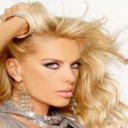

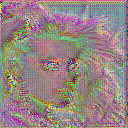

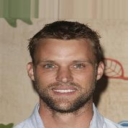

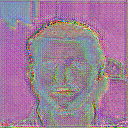

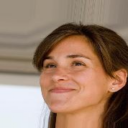

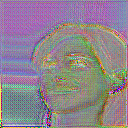

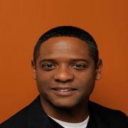

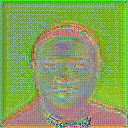

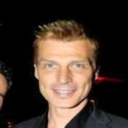

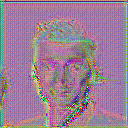

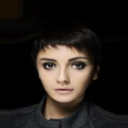

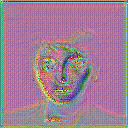

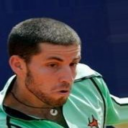

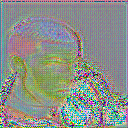

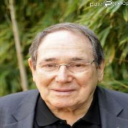

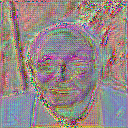

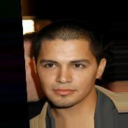

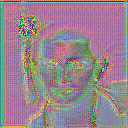

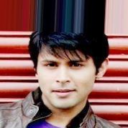

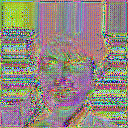

In [21]:
with torch.no_grad():
    out_images=Unet(3, 32, 3)(celeb_tensor) 
display(*[tensorToImage(image) for image in [sub[item] for item in range(len(celeb_tensor)) for sub in [celeb_tensor, out_images]]])
    

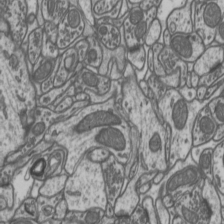

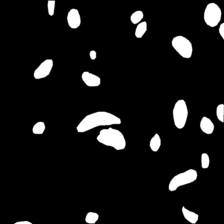

torch.Size([1, 224, 224])


In [22]:
# loading testing dataset for UNET
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),            # Convert images to PyTorch tensors
])

mitochon_source=datasets.ImageFolder(root='mitochondria/images', transform=transform)
mitochon_truth=datasets.ImageFolder(root='mitochondria/masks', transform=transform)

display(tensorToImage(mitochon_source[0][0], lambda x: x))
display(tensorToImage(mitochon_truth[0][0], lambda x: x))

print(mitochon_source[0][0].shape)

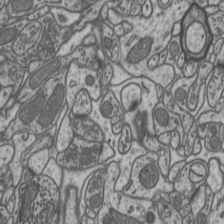

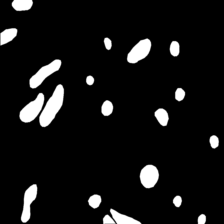

In [23]:
from torch.utils.data import Dataset, random_split

class MitochondriaDataset(Dataset):
    def __init__(self, images, truth):
        self.images=images
        self.truth=truth
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx][0], self.truth[idx][0]

mitochon_data=MitochondriaDataset(mitochon_source, mitochon_truth)

train_size=int(len(mitochon_data)*0.8)
test_size=len(mitochon_data)-train_size

mitochon_train, mitochon_test=random_split(mitochon_data, [train_size, test_size])
print_idx=150
display(tensorToImage(mitochon_train[print_idx][0], lambda x:x))
display(tensorToImage(mitochon_train[print_idx][1], lambda x:x))


In [24]:
# testing unet on mitochondria dataset
model=Unet(1, 64, 1)
# model=train_unet(mitochon_train, mitochon_test, model, nn.BCEWithLogitsLoss(), torch.optim.Adam(model.parameters()), 25, 4)

In [25]:
# model=train_unet(unet_input, validation_input, model, nn.BCEWithLogitsLoss(), torch.optim.Adam(model.parameters()), 25, 4)

In [26]:
# load best model
load_model=Unet(1, 64, 1)
load_model.load_state_dict(torch.load("model.pt"))
model.eval()

C:\Users\User\AppData\Local\Temp\ipykernel_14028\1469636480.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load("model.pt"))


Unet(
  (llayer1): Conv_Block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (llayer2): Down_Block(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (1): Conv_Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
         

In [27]:
test_data=next(iter(DataLoader(mitochon_test, shuffle=True, batch_size=len(mitochon_test))))

test_images=test_data[:][0]
test_truth=test_data[:][1]

with torch.no_grad():
    output=load_model(test_images)

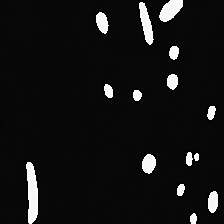

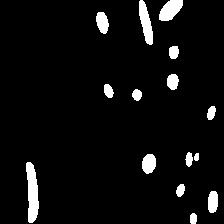

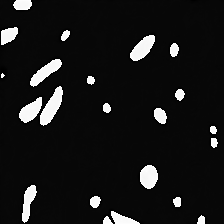

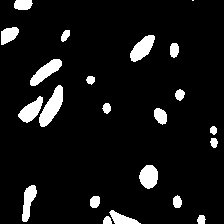

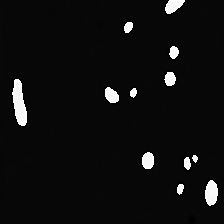

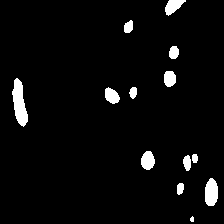

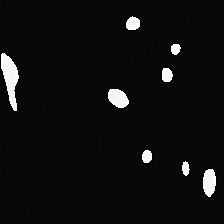

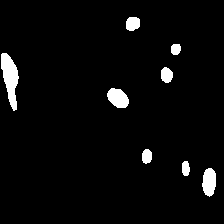

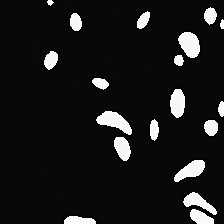

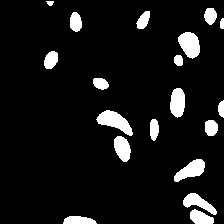

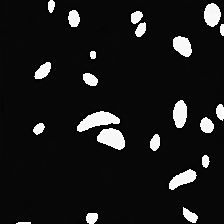

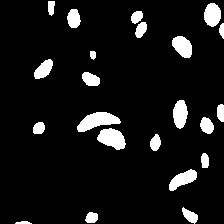

In [28]:
display(*[tensorToImage(lst[i], lambda x: torch.round(x)) for i in range(len(output)//10) for lst in [output, test_truth]])

In [29]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, max_time_steps, dims, n=10000):
        super(SinusoidalPositionalEncoding, self).__init__()

        k=torch.arange(dims//2)
        t=torch.arange(max_time_steps).unsqueeze(dim=1)

        self.embeds=torch.zeros(max_time_steps, dims, requires_grad=False)
        self.embeds[:, 0::2]=torch.sin(t/(n**(2*k/dims)))
        self.embeds[:, 1::2]=torch.cos(t/(n**(2*k/dims)))
    
    def forward(self, t):
        return self.embeds[t, :]
    
    def to_device(self, device):
        self.embeds=self.embeds.to(device)
        self=self.to(device)

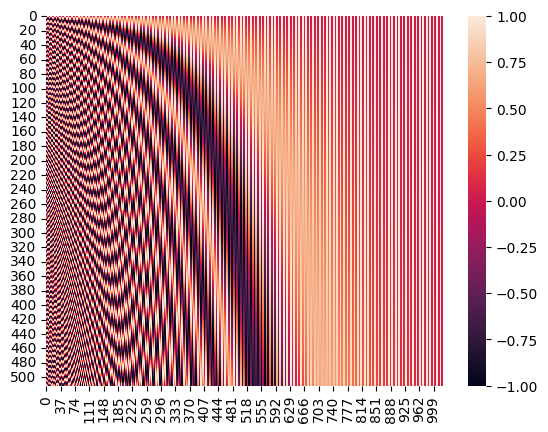

In [30]:
import seaborn as sns
sin_enc=SinusoidalPositionalEncoding(512, 1024)
ax = sns.heatmap(sin_enc(torch.arange(512)))
plt.show()

In [31]:
from einops import rearrange
class ConvTimeBlock(nn.Module):
    def __init__(self, in_channels, num_filters, t_size=None):
        super(ConvTimeBlock, self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
        )
        if t_size is not None:
            self.time_proj=nn.Sequential(nn.ReLU(), nn.Linear(t_size, num_filters))
        else:
            self.time_proj=None
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True)
        )

    def forward(self, input, t_emb=None):
        input=self.conv1(input)
        if t_emb is not None:
            t_emb=self.time_proj(t_emb)
            input=rearrange(t_emb, "b c -> b c 1 1")+input
        return self.conv2(input)

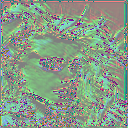

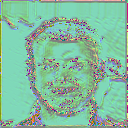

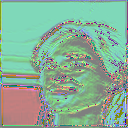

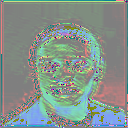

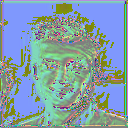

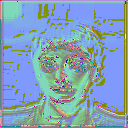

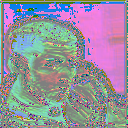

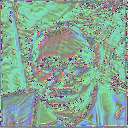

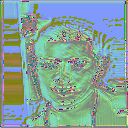

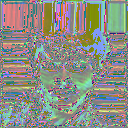

In [32]:
with torch.no_grad():
    testConvTimeBlock=ConvTimeBlock(3, 64, 1024)(celeb_tensor, sin_enc(tensor([25])))
    testConvTimeBlock=ConvTimeBlock(64, 3, 1024)(testConvTimeBlock, sin_enc(tensor([9])))
display(*[tensorToImage(image) for image in testConvTimeBlock])

In [33]:
def random_time_steps(num_time_steps, min=0, max=256):
    return torch.round((max-min)*torch.rand(num_time_steps)+min).int()

In [34]:
from torch.distributions.normal import Normal
import torch.profiler as profiler

class DownTimeBlock(nn.Module):
    def __init__(self, in_channels, num_filters, t_size=None):
        super(DownTimeBlock, self).__init__()
        self.pool=nn.MaxPool2d(kernel_size=(2,2))
        self.conv=ConvTimeBlock(in_channels, num_filters, t_size)

    def forward(self, input, t_emb):
        input=self.pool(input)
        return self.conv(input, t_emb)
    
class UpTimeBlock(nn.Module):
    def __init__(self, in_channels, num_filters, t_size=None):
        super(UpTimeBlock, self).__init__()
        self.upsample=nn.ConvTranspose2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(2,2), stride=2, padding=0)
        self.conv=ConvTimeBlock(in_channels, num_filters, t_size)

    def forward(self, input, skip_connection, t_emb=None):
        diffH=skip_connection.shape[2]-input.shape[2]*2
        diffW=skip_connection.shape[3]-input.shape[3]*2
        upsampled_input=self.upsample(input)
        upsampled_input=nn.functional.pad(upsampled_input, (diffW//2, diffW-diffW//2, diffH//2, diffH-diffH//2))
        cat_input=torch.cat([skip_connection, upsampled_input], dim=1)
        return self.conv(cat_input, t_emb)

In [35]:
class DiffusionModel(nn.Module):
    def __init__(self, in_channels, out_channels, num_filters, num_timesteps=None, starting_var=0.0002, ending_var=0.02, device="cpu"):
        super(DiffusionModel, self).__init__()

        self.device=device

        # variance scheduler and time embedding
        self.sin_enc=SinusoidalPositionalEncoding(num_timesteps, num_timesteps*2)
        self.variance_schedule=torch.linspace(starting_var, ending_var, num_timesteps)
        self.alpha=1-self.variance_schedule
        self.alpha_bar=torch.cumprod(self.alpha, 0)

        # unet layers
        self.llayer1=ConvTimeBlock(in_channels, num_filters, num_timesteps*2)
        self.llayer2=DownTimeBlock(num_filters, num_filters*2, num_timesteps*2)
        self.llayer3=DownTimeBlock(num_filters*2, num_filters*4, num_timesteps*2)
        self.bottom=DownTimeBlock(num_filters*4, num_filters*8, num_timesteps*2)
        self.rlayer1=UpTimeBlock(num_filters*8, num_filters*4, num_timesteps*2)
        self.rlayer2=UpTimeBlock(num_filters*4, num_filters*2, num_timesteps*2)
        self.rlayer3=UpTimeBlock(num_filters*2, num_filters, num_timesteps*2)
        self.out_conv=nn.Conv2d(in_channels=num_filters, out_channels=out_channels, kernel_size=1)

    def forward(self, input, timesteps):
        # get time embedding
        t_emb=self.sin_enc(timesteps)

        # run input through unet
        llayer1=self.llayer1(input, t_emb)
        llayer2=self.llayer2(llayer1, t_emb)
        llayer3=self.llayer3(llayer2, t_emb)
        rlayer=self.bottom(llayer3, t_emb)
        rlayer=self.rlayer1(rlayer, llayer3, t_emb)
        rlayer=self.rlayer2(rlayer, llayer2, t_emb)
        rlayer=self.rlayer3(rlayer, llayer1, t_emb)
        return self.out_conv(rlayer)
    
    def batch(self, x, timesteps):
        # predict noisy images for each timestep
        x=self.bulk_timesteps_to_noise(x, timesteps)
        batch_sz=x.shape[0]
        x=x.view(-1, x.shape[2], x.shape[3], x.shape[4])

        # get noise for timestep t
        timesteps=timesteps.repeat(1, batch_sz).view(-1)
        y=torch.randn_like(x)
        alpha_bar_t=self.alpha_bar[timesteps][:, None, None, None]
        x=torch.sqrt(alpha_bar_t)*x+torch.sqrt(1-alpha_bar_t)*y

        # return added noise and predicted added noise
        return self.forward(x, timesteps), y

    def train_one_epoch_diffusion(self, dataloader, loss_fn, optimizer, num_batches, num_timesteps, timestep_limit):
        running_loss=0
        data_itr=iter(dataloader)
        timesteps=torch.arange(num_timesteps).int().to(self.device)                                                 # calc timesteps for batch
        for i in range(num_batches):
            # Forward pass
            batchInput=next(data_itr)[0].to(self.device)                                                                # fetch batch data
            for j in range(0, num_timesteps, timestep_limit):
                output, truth=self.batch(batchInput, timesteps[j:j+timestep_limit])                                   # calc predictions
                loss = loss_fn(output, truth)

                # Backward pass
                loss.backward()

            # Update weights
            optimizer.step()
            optimizer.zero_grad()
            running_loss+=loss.item()
        return running_loss/num_batches

    def train_diffusion(self, data, loss_fn, optimizer, epochs, batch_size, batches_per_epoch, num_timesteps, gpu_image_limit):
        # move loss/optimizer to device
        loss_fn=loss_fn.to(self.device)

        torch.backends.cudnn.benchmark=True

        dataloader=torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

        # warm up
        self.train_one_epoch_diffusion(dataloader=dataloader, loss_fn=loss_fn, optimizer=optimizer, num_batches=1, num_timesteps=2, timestep_limit=1)
        print('WARMUP COMPLETE')

        for epoch in range(epochs):
            # train for 1 epoch
            model.train(True)
            avg_loss=self.train_one_epoch_diffusion(dataloader, loss_fn, optimizer, batches_per_epoch, num_timesteps, gpu_image_limit//batch_size)
            print('EPOCH: ', epoch, 'AVG LOSS: ', avg_loss)

            torch.save(model.state_dict(), "diffusion8.pt")

    def to_device(self, device):                                                                                    # moves model to device
        self.device=device
        self.alpha=self.alpha.to(device)
        self.alpha_bar=self.alpha_bar.to(device)
        self.variance_schedule=self.variance_schedule.to(device)
        self.sin_enc.to_device(device)
        self=self.to(device)

    # helper functions for prepping data during training
    def forward_approx(self, img, timestep):                                                                        # approximates gaussian noise of image after t timesteps
        # mean=torch.sqrt(self.alpha_bar[timestep])*img
        # std=1-self.alpha_bar[timestep]
        return torch.sqrt(self.alpha_bar[timestep])*img+torch.sqrt(1-self.alpha_bar[timestep])*torch.randn_like(img)
        # return normal(mean=mean, std=std, device=self.device)

    def bulk_timesteps_to_noise(self, imgs, timesteps):                                                             # Takes in tensor of images and returns noisified images at each timestep in tensor form with shape [# images, # time_steps, img size]
        batch_size, num_timesteps, *img_shape = imgs.size(0), timesteps.size(0), imgs.size(1), imgs.size(2), imgs.size(3)
        
        # Initialize an empty tensor to store the noisified images
        noisified_imgs = torch.empty((batch_size, num_timesteps, *img_shape), device=self.device)
        
        for i in range(num_timesteps):
            # Get the current timestep for the entire batch
            current_timestep = timesteps[i]
            # Approximate the noise for the entire batch at the current timestep
            noisified_imgs[:, i] = self.forward_approx(imgs, current_timestep)
        return noisified_imgs

In [ ]:
# in_channels, out_channels, num_filters, num_timesteps, starting_var, ending_var, device=cpu
params=(3, 3, 64, 1024, 0.00001, 0.02)
model=DiffusionModel(*params)

In [ ]:
model.to_device("cuda")
model.train_diffusion(data=celebs, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam(model.parameters(), weight_decay=1e-5, lr=5e-4), epochs=100000, batch_size=1, batches_per_epoch=1, num_timesteps=1024, gpu_image_limit=16)

NameError: name 'model' is not defined

In [88]:
load_diffusion=DiffusionModel(*params)
load_diffusion.load_state_dict(torch.load("diffusion7.pt"))

C:\Users\User\AppData\Local\Temp\ipykernel_19892\1192796220.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_diffusion.load_state_dict(torch.load("diffusion7.pt"))


<All keys matched successfully>

torch.Size([1, 64, 3, 64, 64])


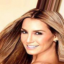

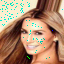

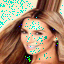

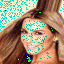

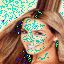

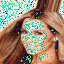

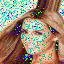

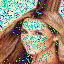

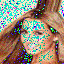

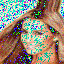

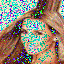

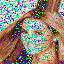

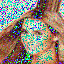

In [89]:
imgs=model.bulk_timesteps_to_noise(celebs[0][0][None, :, :, :].to('cuda'), torch.arange(64).to('cuda'))
print(imgs.shape)
display(*[tensorToImage(im) for i, im in enumerate(imgs[0]) if i%5==0])

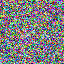

299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33

In [191]:
diffusion=[]
starting_timestep=300
image=20020
with torch.no_grad():
    load_diffusion.to_device("cuda")
    curr = load_diffusion.forward_approx(celebs[image][0].to('cuda'), starting_timestep).to('cuda')
    # curr = torch.randn_like(celebs[0][0]).to('cuda')
    # curr = torch.clip(curr, -1, 1)
    display(tensorToImage(curr))
    curr = curr[None, :, :, :]
    timesteps=torch.arange(starting_timestep).int().view(starting_timestep, 1).to('cuda')
    for i in range(starting_timestep-1, -1, -1):
        print(i)
        diffusion.append(curr)
        alpha=load_diffusion.alpha[timesteps[i][0]]
        alpha_bar=load_diffusion.alpha_bar[timesteps[i][0]]
        std=torch.sqrt(load_diffusion.variance_schedule[timesteps[i][0]])
        curr=(1/alpha)*(curr-(1-alpha)/(torch.sqrt(1-alpha_bar))*load_diffusion(curr, timesteps[i]))+(std*torch.randn_like(curr) if i>1 else 0)

In [192]:
diffusion.append(curr)

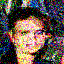

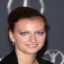

In [193]:
# display(*[tensorToImage(torch.clip(im[0], min=-1, max=1)) for i, im in enumerate(diffusion) if i%50==0])
display(tensorToImage(torch.clip(diffusion[-1][0], min=-1, max=1)))
display(tensorToImage(celebs[image][0]))

In [194]:
load_diffusion2=DiffusionModel(*params)
load_diffusion2.load_state_dict(torch.load("diffusion5.pt"))

C:\Users\User\AppData\Local\Temp\ipykernel_19892\1445929939.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_diffusion2.load_state_dict(torch.load("diffusion5.pt"))


<All keys matched successfully>

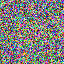

299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33

In [195]:
diffusion2=[]
with torch.no_grad():
    load_diffusion2.to_device("cuda")
    curr = load_diffusion2.forward_approx(celebs[image][0].to('cuda'), starting_timestep).to('cuda')
    # curr = torch.randn_like(celebs[0][0]).to('cuda')
    # curr = torch.clip(curr, -1, 1)
    display(tensorToImage(curr))
    curr = curr[None, :, :, :]
    timesteps=torch.arange(starting_timestep).int().view(starting_timestep, 1).to('cuda')
    for i in range(starting_timestep-1, -1, -1):
        print(i)
        diffusion2.append(curr)
        alpha=load_diffusion.alpha[timesteps[i][0]]
        alpha_bar=load_diffusion.alpha_bar[timesteps[i][0]]
        std=torch.sqrt(load_diffusion.variance_schedule[timesteps[i][0]])
        curr=(1/alpha)*(curr-(1-alpha)/(torch.sqrt(1-alpha_bar))*load_diffusion(curr, timesteps[i]))+(std*torch.randn_like(curr) if i>1 else 0)
diffusion2.append(curr)

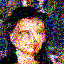

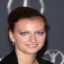

In [196]:
# display(*[tensorToImage(torch.clip(im[0], min=-1, max=1)) for i, im in enumerate(diffusion) if i%50==0])
display(tensorToImage(torch.clip(diffusion2[-1][0], min=-1, max=1)))
display(tensorToImage(celebs[image][0]))

In [197]:
print('MODEL 7 LOSS: ', nn.functional.mse_loss(torch.clip(diffusion[-1][0], min=-1, max=1), celebs[image][0].to('cuda')))
print('MODEL 6 LOSS: ', nn.functional.mse_loss(torch.clip(diffusion2[-1][0], min=-1, max=1), celebs[image][0].to('cuda')))
print('COMPARISON LOSS: ', nn.functional.mse_loss(torch.clip(diffusion2[-1][0], min=-1, max=1), torch.clip(diffusion[-1][0], min=-1, max=1)))

MODEL 7 LOSS:  tensor(0.1970, device='cuda:0')
MODEL 6 LOSS:  tensor(0.1851, device='cuda:0')
COMPARISON LOSS:  tensor(0.3527, device='cuda:0')
